In [1]:
from IPython.display import display, Math, Markdown
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage
import scipy.optimize as opt
import sys

In [2]:
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# (phi_min, phi_max) are the min/max values of the wavefront phase
# r_max is approximately the maximum radius of the image
# r_mid ~ 0.2*r_max is user-specified, with a value that might need tweaking
# r0 is the radial curvature of phi(r), for r < r_mid
def spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0):
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    phi_mid = phi_max * (1. - (r_mid/r0)**2)
    c0 = (phi_mid - phi_min) / (1. - r_mid/r_max)
    
    f_1 = phi_max * (1. - rsq/r0**2)
    f_2 = phi_min + c0 * (1. - r/r_max)
    return np.where(r<=r_mid, f_1, f_2)

# r0 and phi_max are the fitting parameters
def spline_wfs_fit(params, x, y, data, xc, yc, r_mid, r_max, phi_min):
    r0 = params[0]
    phi_max = params[1]
    g = spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0)
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    weighted_diff = np.where(r<=r_mid, (g - data.reshape(g.shape))/r, 0.)
    return np.linalg.norm(weighted_diff)

In [3]:
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# n0_max is the maximum # of photon counts on a pixel, near the pulse center
# r_rms, the RMS radius of the 2D cylindrically symmetric gaussian
def gaussian_ccd(x, y, xc, yc, n0_max, r_rms):
    return n0_max * np.exp(-(((x-xc)/r_rms)**2 + ((y-yc)/r_rms)**2))

# r_rms and n0_max are the fitting parameters
def gaussian_ccd_fit(params, x, y, xc, yc, data, r_mid):
    r_rms = params[0]
    n0_max = params[1]
    g = gaussian_ccd(x, y, xc, yc, n0_max, r_rms)
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    weighted_diff = np.where(r<r_mid, (g - data.reshape(g.shape))/r, 0.)
    return np.linalg.norm(weighted_diff)

In [4]:
# compute an azimuthally averaged radial profile
# Code adapted from https://github.com/vicbonj/radialprofile/blob/master/radialProfile.py

def azimuthalAverage(image, centerx, centery, type='mean'):
    '''
    Compute spherically symetric profiles around a center
    Returns
    -------
    profiles, errors, distance to the center in pixels
    '''

    y, x = np.indices(image.shape)
    r = np.hypot(x - centerx, y - centery)

    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    r_int = r_sorted.astype(int)

    deltar = r_int[1:] - r_int[:-1]
    rind = np.where(deltar)[0]
    rind2 = rind+1
    rind3 = np.zeros(len(rind2)+1)
    rind3[1:] = rind2
    rind3 = rind3.astype('int')

    if type == 'mean':
        aaa = [np.nanmean(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'median':
        aaa = [np.nanmedian(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'mode':
        aaa_list = [i_sorted[rind3[i]:rind3[i+1]] for i in range(len(rind3)-1)]
        aaa = []
        for part in aaa_list:
            if len(part) == 1:
                counts, xed = np.histogram(part, bins=len(part))
            elif (len(part) > 1) & (len(part) < 40):
                counts, xed = np.histogram(part, bins=int(len(part)/2))
            else:
                counts, xed = np.histogram(part, bins=20)
            if len(xed) != 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
            elif len(xed) == 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
    else:
        raise ValueError('Nope')
    aaa_std = [np.nanstd(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    dist_r = [np.mean(r_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    return np.array(aaa), np.array(aaa_std), np.array(dist_r)

In [5]:
# specify the path to the diagnostic data files
# dir_name = 'rslaser/package_data/'
dir_name = '../../../rslaser/package_data/'
ccd_name = 'ccd_peak_timing.txt'
wfs_name = 'wfs_peak_timing.txt'

# read the pixel size from the diagnostic metadata file
# with open("rslaser/package_data/camera_sensor_info.txt") as fh:
with open("../../../rslaser/package_data/camera_sensor_info.txt") as fh:
    for line in fh:
        if line.startswith("\"pixel_size_h_microns\""):
            pixel_size = float(line.split(":")[-1].split(",")[0])  # microns
display(Markdown(' pixel size is {} [$\mu m$] by {} [$\mu m$]'.format(pixel_size,pixel_size)))

 pixel size is 6.9 [$\mu m$] by 6.9 [$\mu m$]

In [6]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data = np.genfromtxt(dir_name+wfs_name, skip_header=1, skip_footer=0)

# convert from microns to radians
lambda0_micron = 0.8
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron
# print(' ')
# print('rad_per_micron = ', rad_per_micron)

# clean up any NaN's
wfs_data[np.isnan(wfs_data)] = 777
wfs_data[np.where(wfs_data==777)] = np.min(wfs_data)
# print(' ')
# print('np.shape(wfs_data) = ', np.shape(wfs_data))
# print('wfs_data = ')
# print(wfs_data)

x = np.linspace(0, wfs_data.shape[1] - 1, wfs_data.shape[1])
y = np.linspace(0, wfs_data.shape[0] - 1, wfs_data.shape[0])
x, y = np.meshgrid(x, y)
# print(' ')
# print('np.shape(x) = ', np.shape(x))
# print('x = ', x)
# print('y = ', y)

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)
# print(' ')
print('phi_min = ', phi_min)
print('phi_max = ', phi_max)

phi_min =  -2.481696570337631
phi_max =  2.481696570337631


In [7]:
# parse the intensity (CCD) diagnostic data file
ccd_data = np.genfromtxt(dir_name+ccd_name, skip_header=1)
# print(' ')
# print('np.shape(ccd_data) = ', np.shape(ccd_data))
# print('ccd_data = ')
# print(ccd_data)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

n0_min=np.min(ccd_data)
n0_max=np.max(ccd_data)
n0_tot = np.sum(ccd_data)
# print(' ')
print('n0_min = ', n0_min)
print('n0_max = ', n0_max)
print('n0_tot = ', n0_tot)

n0_min =  0.0
n0_max =  88730.0
n0_tot =  26371223.0


In [8]:
# find the center of the laser pulse
# in many cases, the WFS data is cleaner, with a well-defined center
# in comparison, the intensity data can be blotchy and asymmetric near the center
# when close to a waist, the WFS data does *NOT* have a well-defined center

# check whether the WFS data has a narrow range of phases
# if so, the laser pulse is close to a waist
CLOSE_TO_WAIST = False
if (phi_max-phi_min) < 0.1*math.pi:
    print('Laser pulse is close to a waist!')
    CLOSE_TO_WAIST = True

yc_ccd, xc_ccd = ndimage.measurements.center_of_mass(ccd_data)
if CLOSE_TO_WAIST:
    # take the center from the CCD data
    yc_wfs, xc_wfs = 'UNDEFINED', 'UNDEFINED'
    (xc0, yc0) = (xc_ccd, yc_ccd)
    print('xc_ccd ~ {0:4.1f}'.format(xc_ccd)+'; yc_ccd ~ {0:4.1f} [pixels]'.format(yc_ccd))
else:
    # take the center from the WFS data
    yc_wfs, xc_wfs = ndimage.measurements.center_of_mass(wfs_data)
    (xc0, yc0) = (xc_wfs, yc_wfs)
    print('xc_wfs ~ {0:4.1f}'.format(xc_wfs)+'; yc_wfs ~ {0:4.1f} [pixels]'.format(yc_wfs))
    # display(Markdown('$x_{{c,wfs}}$ ~ {0:3.0f}'.format(xc_wfs*pixel_size)+'; $y_{{c,wfs}}$ ~ {0:3.0f} [$\mu m$]'.format(yc_wfs*pixel_size)))

# Approximate value for the maximum radius of the diagnostic images
r_max = max(np.linalg.norm(x[-1,0] - xc0),np.linalg.norm(x[0,-1] - yc0))
print('r_max = ', r_max)

xc_wfs ~ 19.3; yc_wfs ~ 15.7 [pixels]
r_max =  23.26555683264078


In [9]:
# use nonlinear optimization to find the radius of curvature for ph(r), near r=0
if CLOSE_TO_WAIST:
    r_mid = 2.*r_max
    phi_avg = 0.5*(phi_min + phi_max)
    phi_min = phi_avg
    phi_max = phi_avg
else:
    r_mid = 0.18*r_max

print('r_mid = ', r_mid)
r0 = 0.2*r_max
x0=(r0, phi_max)

args=(x, y, wfs_data.flatten(), xc0, yc0, r_mid, r_max, phi_min)

result = opt.minimize(spline_wfs_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print(' ')
print('result = ', result)

r_mid =  4.18780022987534
 
result =   final_simplex: (array([[5.74972209, 2.40690723],
       [5.74972203, 2.40690724],
       [5.74972199, 2.40690722]]), array([0.48265811, 0.48265811, 0.48265811]))
           fun: 0.4826581098520138
       message: 'Optimization terminated successfully.'
          nfev: 112
           nit: 58
        status: 0
       success: True
             x: array([5.74972209, 2.40690723])


In [10]:
xc = xc0
yc = yc0
(r0, phi_max) = result.x
print('xc = ', xc)
print('yc = ', yc)
print('r0 = ', r0)
print('phi_min = ', phi_min)
print('phi_max = ', phi_max)

wfs_fit = spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0)
print(' ')
print('wfs_fit = ', wfs_fit)

xc =  19.346049824071976
yc =  15.73444316735922
r0 =  5.749722090059864
phi_min =  -2.481696570337631
phi_max =  2.406907226867499
 
wfs_fit =  [[-2.79808654 -2.65277246 -2.51078081 ... -2.55412694 -2.69717513
  -2.84345089]
 [-2.68097534 -2.5318427  -2.38586775 ... -2.43045782 -2.57743869
  -2.72748225]
 [-2.56879288 -2.41580594 -2.26578907 ... -2.31164377 -2.46260853
  -2.61644928]
 ...
 [-2.51799585 -2.36319615 -2.21127067 ... -2.25772338 -2.41056698
  -2.56619154]
 [-2.62773821 -2.47680141 -2.32893718 ... -2.37411806 -2.52296193
  -2.67478366]
 [-2.74258421 -2.59548548 -2.45163477 ... -2.49556118 -2.64044562
  -2.78848301]]


In [11]:
profile, deviations, r = azimuthalAverage(wfs_data, xc0, yc0)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])

phi_mid = phi_max * (1. - (r_mid/r0)**2)
c0 = (phi_mid - phi_min) / (1. - r_mid/r_max)

f_1 = phi_max * (1. - np.power(r,2)/r0**2)
f_2 = phi_min + c0 * (1. - r/r_max)
fit = np.where(r<=r_mid, f_1, f_2)
print(' fit = ', fit)

 
 r =  [ 0.73432222  1.6218398   2.56852615  3.5372657   4.52213611  5.5456755
  6.53627574  7.52265561  8.52433995  9.51954138 10.54148288 11.53947976
 12.51207872 13.51309658 14.51813816 15.52503759 16.49889559 17.4999767
 18.50155056 19.49837144 20.47420529 21.47380497 22.48116871 23.48167532
 24.43478639]
 profile =  [ 2.38335395  2.18429781  1.88235346  1.49459271  1.10969997  0.72485286
  0.40768074  0.13885705 -0.11494475 -0.31116526 -0.51662326 -0.70122413
 -0.88015838 -1.04339203 -1.20608786 -1.34555898 -1.5366774  -1.68548844
 -1.83908054 -1.96159279 -2.0276462  -2.11524407 -2.1825039  -2.28441604
 -2.35480132]
 fit =  [ 2.36764825  2.21540159  1.92658396  1.49594366  1.0667683   0.87299398
  0.68545563  0.49871628  0.30907951  0.12067007 -0.07280173 -0.2617404
 -0.44587078 -0.63538137 -0.82565372 -1.0162778  -1.20064654 -1.3901691
 -1.57978495 -1.76850098 -1.95324379 -2.14248589 -2.33319787 -2.52261167
 -2.70305264]


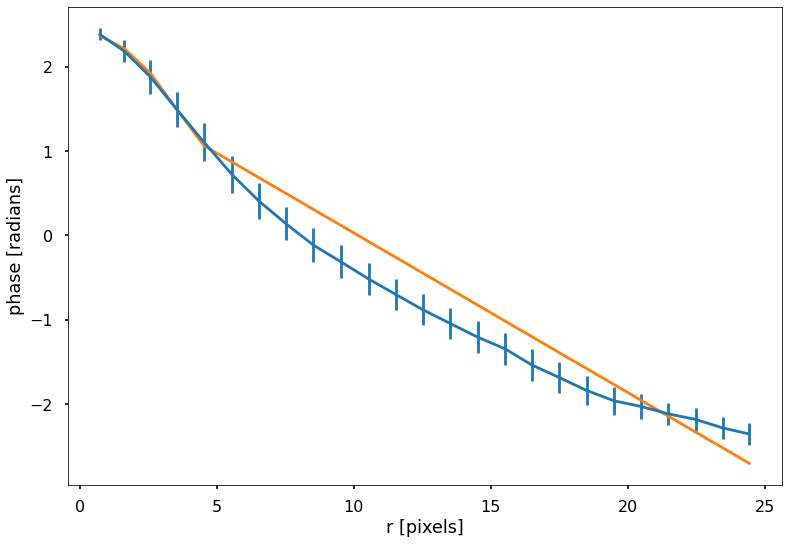

In [12]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('phase [radians]')

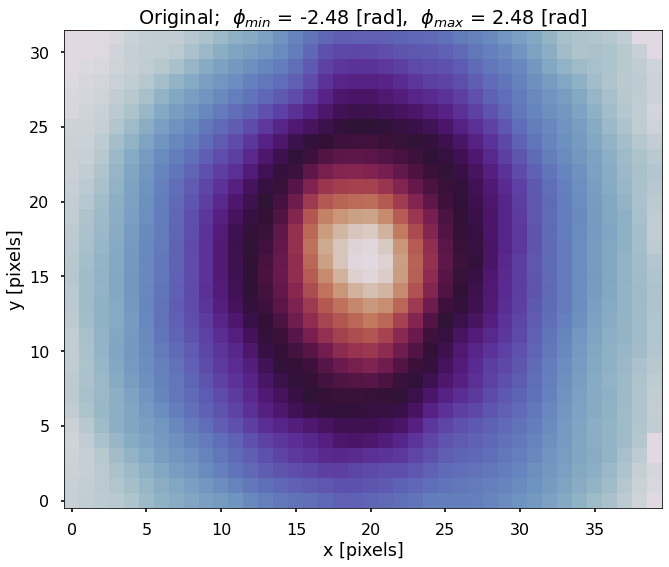

In [13]:
# plot the original data
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(wfs_data, cmap='twilight', vmin=np.min(wfs_data), vmax=np.max(wfs_data))
    ax.invert_yaxis()
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    ax.set_title(r'Original;  $\phi_{{min}}$ ={0:6.2f} [rad]'.format(np.min(wfs_data))+',  $\phi_{{max}}$ ={0:5.2f} [rad]'.format(np.max(wfs_data)))

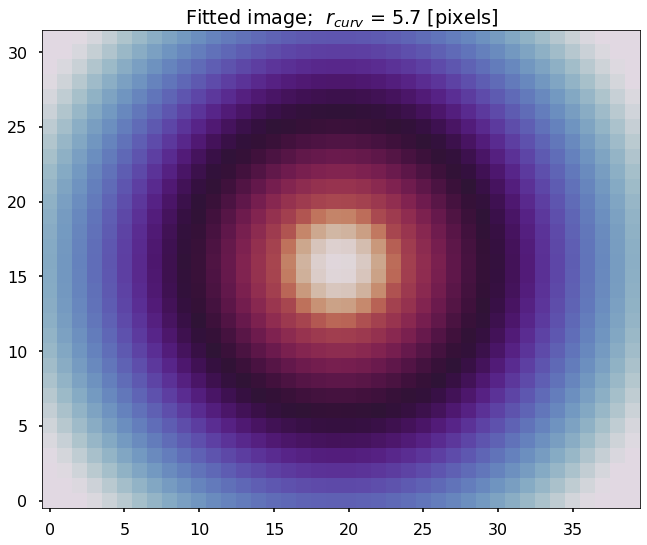

In [14]:
# plot the fitted image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(wfs_fit, cmap='twilight', vmin=np.min(wfs_data), vmax=np.max(wfs_data))
    ax.invert_yaxis()
    ax.set_title(r'Fitted image;  $r_{{curv}}$ ={0:4.1f} [pixels]'.format(r0))

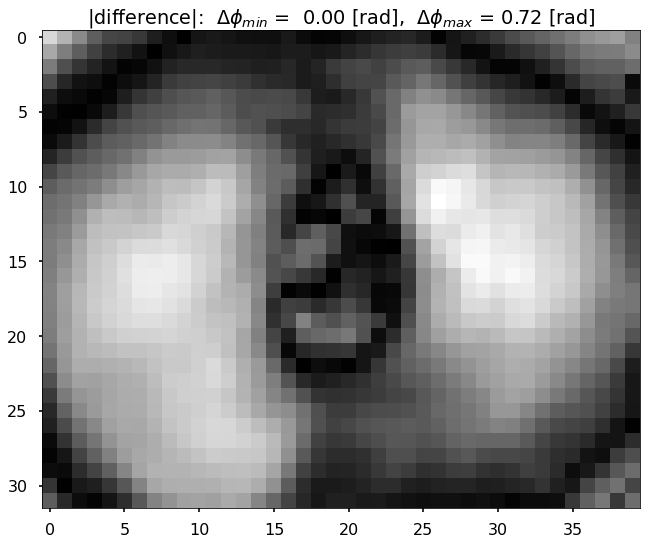

In [15]:
# plot the difference between the original and the Gaussian fit
 
wfs_diff = np.abs(wfs_data - wfs_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.invert_yaxis()
    ax.imshow(wfs_diff, cmap='gray', vmin=np.min(wfs_diff), vmax=np.max(wfs_diff))
    ax.set_title(r'|difference|:  $\Delta\phi_{{min}}$ ={0:6.2f} [rad]'.format(np.min(wfs_diff))+',  $\Delta\phi_{{max}}$ ={0:5.2f} [rad]'.format(np.max(wfs_diff)))

In [16]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('wfs_data = ')
# print(wfs_data)
min_data = np.min(wfs_data)
max_data = np.max(wfs_data)
print('min original = ', min_data)
print('max original = ', max_data)

print(' ')
print('*************************')
# print('wfs_fit = ')
# print(wfs_fit)
min_fit = np.min(wfs_fit)
max_fit = np.max(wfs_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('wfs_diff = ')
# print(wfs_diff)
min_diff = np.min(wfs_diff)
max_diff = np.max(wfs_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  -2.481696570337631
max original =  2.481696570337631
 
*************************
min fitted =  -2.843450894821716
max fitted =  2.393054411580227
 
*************************
min diff =  0.00018463664359869014
max diff =  0.7155431069831247


In [17]:
# Now let's fit a Gaussian to the intensity data from the CCD diagnostic file
r_rms = 0.2*r_max
x0=(r_rms, n0_max)

r_mid = 0.4*r_max
args=(x, y, xc, yc, ccd_data.flatten(), r_mid)

result = opt.minimize(gaussian_ccd_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print('result = ', result)

result =   final_simplex: (array([[7.29576428e+00, 8.53410358e+04],
       [7.29576428e+00, 8.53410358e+04],
       [7.29576428e+00, 8.53410358e+04]]), array([27452.74719345, 27452.74719345, 27452.74719345]))
           fun: 27452.747193446903
       message: 'Optimization terminated successfully.'
          nfev: 174
           nit: 81
        status: 0
       success: True
             x: array([7.29576428e+00, 8.53410358e+04])


In [18]:
(r_rms, nfit_max) = result.x
w0 = r_rms * math.sqrt(2.) * pixel_size
x_rms = r_rms / math.sqrt(2.) * pixel_size
ccd_fit = gaussian_ccd(x, y, xc, yc, n0_max, r_rms).reshape(ccd_data.shape)

# compare the total photon count
nfit_tot = np.sum(ccd_fit)
rel_tot_dif = 100.*(1.-nfit_tot/n0_tot)
print('nfit_tot = {0:4.0f}'.format(nfit_tot))
print('relative difference of total counts = {0:3.1f}%'.format(rel_tot_dif))

# compare the center location with values calculated above
yc_ccd, xc_ccd = ndimage.measurements.center_of_mass(ccd_data) 
print('xc_ccd ~ {0:4.1f}'.format(xc_ccd) + ';  yc_ccd ~ {0:4.1f}'.format(yc_ccd))
print('xc_wfs ~ {0:4.1f}'.format(xc)     + ';  yc_wfs ~ {0:4.1f}'.format(yc))

nfit_tot = 14807587
relative difference of total counts = 43.8%
xc_ccd ~ 19.9;  yc_ccd ~ 14.5
xc_wfs ~ 19.3;  yc_wfs ~ 15.7


In [19]:
profile, deviations, r = azimuthalAverage(ccd_data, xc, yc)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])
fit = nfit_max*np.exp(-(r/r_rms)**2)
print(' fit = ', fit)

 
 r =  [ 0.73432222  1.6218398   2.56852615  3.5372657   4.52213611  5.5456755
  6.53627574  7.52265561  8.52433995  9.51954138 10.54148288 11.53947976
 12.51207872 13.51309658 14.51813816 15.52503759 16.49889559 17.4999767
 18.50155056 19.49837144 20.47420529 21.47380497 22.48116871 23.48167532
 24.43478639]
 profile =  [86177.25       82265.33333333 73985.375      60863.42857143
 53839.5862069  44149.5        38535.58974359 35029.625
 32464.1509434  29815.98333333 27542.88405797 25406.17391304
 22847.8974359  20511.08139535 17081.68131868 14204.61616162
 11253.07058824  8473.56626506  6189.16        4375.19480519
  3325.73214286  2371.87179487  1747.93333333  1173.94117647
   733.2       ]
 fit =  [8.44808511e+04 8.12262645e+04 7.53927534e+04 6.74635378e+04
 5.81174380e+04 4.78881943e+04 3.82452159e+04 2.94734591e+04
 2.17912126e+04 1.55512700e+04 1.05802126e+04 6.99349557e+03
 4.50642537e+03 2.76231889e+03 1.62708732e+03 9.21709564e+02
 5.13024254e+02 2.70668365e+02 1.37478510e+02 

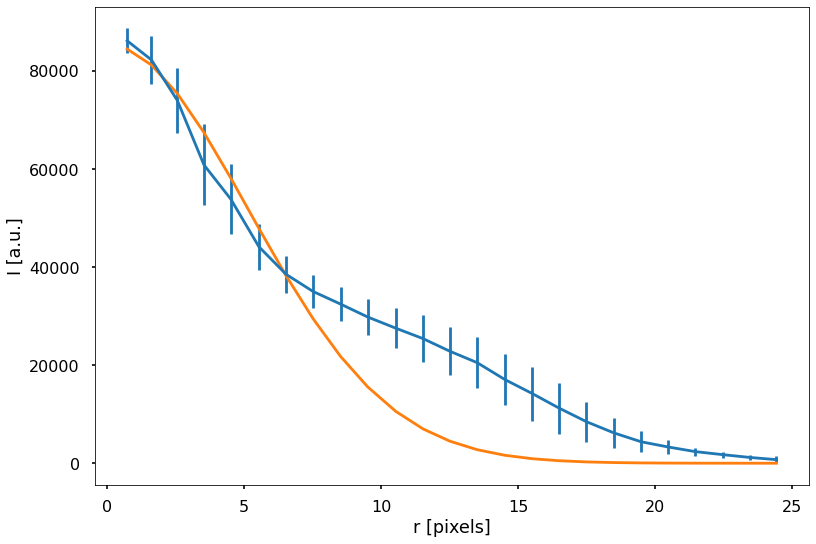

In [20]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('I [a.u.]')

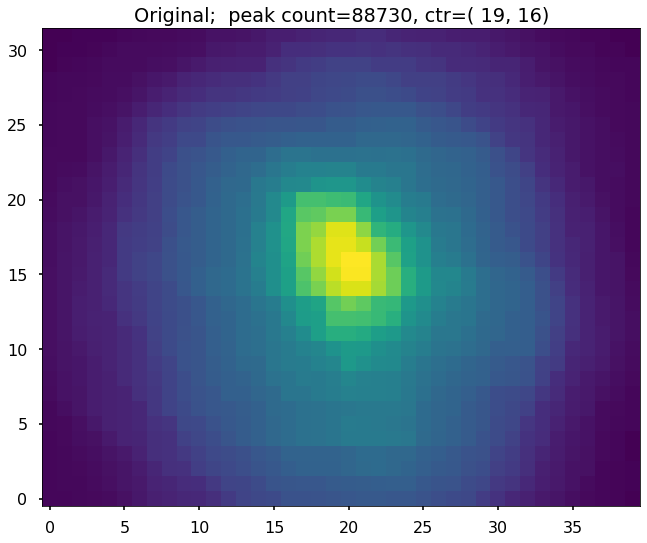

In [21]:
# plot the original image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_data, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title('Original;  peak count={0:4.0f}'.format(n0_max)+', ctr=({0:3.0f},'.format(xc)+'{0:3.0f})'.format(yc))

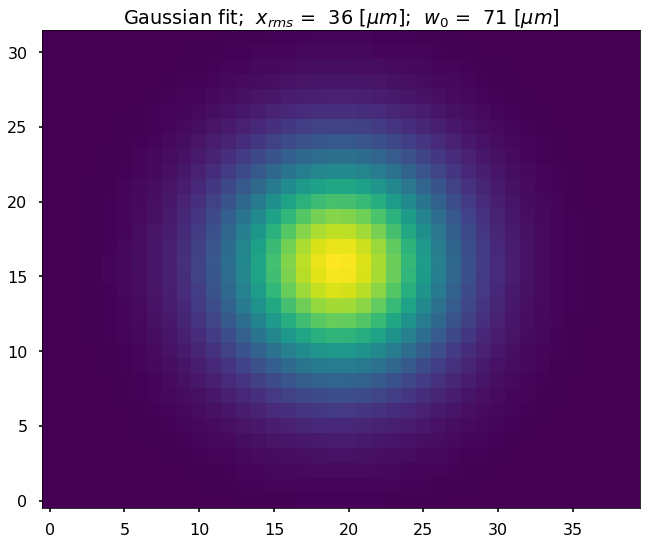

In [22]:
# plot the fitted Gaussian image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_fit, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title(r'Gaussian fit;  $x_{{rms}}$ ={0:4.0f} [$\mu m$]'.format(x_rms) + ';  $w_0$ ={0:4.0f} [$\mu m$]'.format(w0))

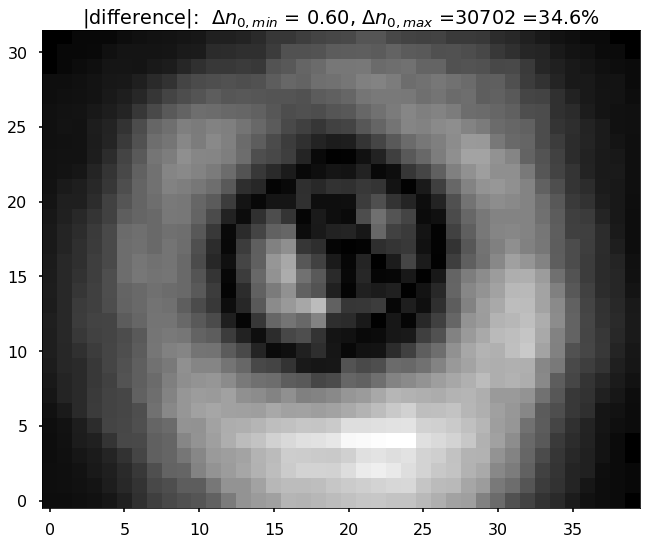

In [23]:
# plot the difference between the original and the Gaussian fit
 
ccd_diff = np.abs(ccd_data - ccd_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_diff, cmap='gray', vmin=np.min(ccd_diff), vmax=np.max(ccd_diff))
    ax.invert_yaxis()
    ax.set_title(r'|difference|:  $\Delta n_{{0, min}}$ ={0:5.2f}'.format(np.min(ccd_diff))+r', $\Delta n_{{0, max}}$ ={0:5.0f}'.format(np.max(ccd_diff))+r' ={0:4.1f}%'.format(100.*(np.max(ccd_diff)/n0_max)))

In [24]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('ccd_data = ')
# print(ccd_data)
min_orig = np.min(ccd_data)
max_orig = np.max(ccd_data)
print('min original = ', min_orig)
print('max original = ', max_orig)

print(' ')
print('*************************')
# print('ccd_fit = ')
# print(ccd_fit)
min_fit = np.min(ccd_fit)
max_fit = np.max(ccd_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('ccd_diff = ')
# print(ccd_diff)
min_diff = np.min(ccd_diff)
max_diff = np.max(ccd_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  0.0
max original =  88730.0
 
*************************
min fitted =  0.5976069433878669
max fitted =  88413.3895068452
 
*************************
min diff =  0.5976069433878669
max diff =  30702.237738520307
